In [1]:
import pandas as pd
import json
import os
import spotipy
import scipy.stats as stats
from spotipy.oauth2 import SpotifyOAuth
import matplotlib.pyplot as plt
import numpy as np
from spotipy.oauth2 import SpotifyClientCredentials
import time
import requests
import seaborn as sb


# Set your Spotify API credentials
os.environ["SPOTIPY_CLIENT_ID"] = "ac3a06f88c94438e904e5fb6f4cd19b9"
os.environ["SPOTIPY_CLIENT_SECRET"] = "da619d1d04794e4cab338a691146fbbd"

# Create a Spotify client
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

# Project Topic

---

### Explanation:

<p>
I had to redo my project due to concerns of the methods not aligning with the class and the inability to test my collaborative filtering model. Instead I will be tackling a regression problem using audio-features stored by Spotify. 
</p>

<p>
Every song stored in the spotify database contain a set of audio-features that define certain aspects of a track. There are certain concrete easily measurable features like tempo, key , mode ... . There are also other features that are derived by the spotify team like danceability, valence(positivity of a song), energy ... . For my project I want to be able to predict a particular audio feature by a combination of other audio features in the database. Since, as of right now, I'm not sure which features are correlated in this write up I will perform some data cleaning and exploratory data analysis to pick the right target and predictor features. I hope that by the end of this notebook I  will have at least a couple features that have moderate correlations to utilize

### Goal:
<p>
For this project I hope to learn more about the complexities that go into multi-linear regression problems and how to prepare data for such a model. I also hope to explore more about how certain aspects of music and how the different musical choices influence each other.
</p>

---

## Data 

For my training data I am using the Spotify Million Playlist Dataset. The Data is a set of a million different playlists each containing a set of at most 250 tracks created by users of the Spotify platform. I obtained the dataset from aicrowd.com https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge.

The data is divided into 1000 different slice files. Each file contains 1000 playlists. The size of each slice is on average 32 MB. I will most likely not be using all one million playlists because of computational limits of the model and APIs I use to fetch additional features below. The beauty of this dataset is that I can control how many slices I want to use. For this initial stage I am only using 1 slice file, which contains 34421 rows. I'm converting the JSON filetype into a tabulated dataframe. I am only using the playlists to get names of tracks and then I will be grouping the dataframe by track id. I am not keeping track of playlists as I am only using the dataset to find valid TrackIDs in the spotify database and then using the spotify API to find the audio-features of each track. The features I am using in the initial dataset are:

- Artist (String)
- Track (String)
- Track ID - The unique identifier for the track in the spotify database (string)
- Artist ID - The unique identifier for the track's artist in the spotify database (String)

I will be using API's later in my data curation below to fetch more unique features for each track. I will be extending the features to include:

- Popularity - Spotify metric describing popularity of a track (Int)
- Danceability - Spotify metric describing danceability of track (FLoat)
- Valence - Spotify metric describing the positivity or happiness of a track (Float)
- Energy - Spotify metric measuring intensity and activity of a track (Float)
- Instrumentalness - Spotify metric measuring likelihood of track being an instrumental (Float)
- Liveness - Spotify metric recording the likelihood of a audience in the track (Float)
- Speechiness- Spotify metric recording the amount of spoken word in a track (FLoat)
- Tempo - :The BPM (beats per minute) of a track (Int)
- Key - : Represents the set of musical keys a track falls into (Int)
- Mode - : Represents a major (0) or minor (1) mode (Int)
- Duration- : The length of a song in seconds (Int)

---

The code below downloads the specified n number of slices, pulls each track and the first 5 features of the track specified above, and converts the JSON data into a dataframe. Each item is unique based on it's Track ID.

## Bonus:

I believe that this project does qualify for bonus credit. I curated this dataset from scratch using a complicated API. I did not follow a guide online that came along with this dataset. I am taking the risk that things might not work out and I will have to spend extra effort to get accurate results.

In [2]:

tracks = pd.DataFrame()

n = 1  # Change this to the number of files you have
for i in range(0, n*1000, 1000):
    filename = f"spotify_million_playlist_dataset/data/mpd.slice.{i}-{i+999}.json"
    
    with open(filename, "r") as f:
        data = json.load(f)

    update_tracks = []
    playlists = pd.json_normalize(data, record_path="playlists")
    
    for _, playlist in playlists.iterrows():
        for track in playlist["tracks"]:
            track["pid"] = playlist["pid"]
            update_tracks.append(track)

    tracks = tracks.append(pd.DataFrame(update_tracks), ignore_index=True)

/tmp/ipykernel_1694/3254814947.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracks = tracks.append(pd.DataFrame(update_tracks), ignore_index=True)


In [3]:

data = pd.DataFrame({"artist" : tracks["artist_name"], 
                            "artist_id": tracks["artist_uri"].apply(lambda x : x.split("spotify:artist:")[1]),
                            "track" : tracks["track_name"],
                            "track_id": tracks["track_uri"].apply(lambda x : x.split("spotify:track:")[1]),
                            "playlist id": tracks["pid"]})

data = data.drop_duplicates(subset="track_id", keep="first")

--- 

We now have a base dataframe to build off of.  I will need some way to collect unique features of each track. The functions defined below use the Spotipy library to accomplish this. The Spotipy library methods send an API call to different Spotify Developer API endpoints returning the popularity metric and unique audio feature values for each track in the dataframe. These are the same features that spotify utilize in their recommendation systems. The process of fetching features with API's is not related to the class so I will spare the details.



In [4]:
import time
import requests

def get_features(func_type, feature_type, ids):
    def fetch_features(batch_ids, max_retries=3, backoff_factor=2):
        retries = 0
        while retries <= max_retries:
            try:
                response = func_type(batch_ids)
                return response
            except requests.exceptions.RequestException as e:
                if retries < max_retries:
                    sleep_time = backoff_factor * (2 ** retries)
                    time.sleep(sleep_time)
                    retries += 1
                else:
                    raise e

    features = {}
    if feature_type == "audio_features":
        for i in range(0, len(ids), 50):
            batch_ids = ids[i:i + 50]
            batch_features = fetch_features(batch_ids)

            for feature in batch_features:
                if feature is not None:
                    features[feature['id']] = feature
    else:
        for i in range(0, len(ids), 50):
            batch_ids = ids[i:i + 50]
            batch_features = fetch_features(batch_ids)

            for feature in batch_features[feature_type]:
                if feature is not None:
                    features[feature['id']] = feature

    return features

--- 

In the code below I am calling my get_features method to fetch the Popularity metric. This will return a python dictionary of track Id (key) and popularity metric (value) for each track in my data. I am also fetching my audio features as well, this will also return a dictionary of all the audio features for each track.

In [5]:
#Get the popularity of each track
track_ids = data["track_id"].drop_duplicates().reset_index(drop=True)
track_features = get_features(sp.tracks, 'tracks', track_ids)
rows = []
for track_id in track_ids:
    if track_id in track_features:
        new_row = {"track_id": track_id}
        new_row["popularity"] = track_features[track_id]["popularity"]
        rows.append(new_row)

track_popularity_df = pd.DataFrame(rows)

    

In [6]:
#Get the audio features of each track

#track_ids = data["Track_ID"].drop_duplicates().reset_index(drop=True)
audio_features = get_features(sp.audio_features, 'audio_features', track_ids)
audio_feature_types = ["acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature", "valence"]
rows = []
for track_id in track_ids:
    new_row = {"track_id": track_id}
    for feature in audio_feature_types:
        new_row[f"{feature}"] =  audio_features[track_id][feature]
    rows.append(new_row)

audio_features_df = pd.DataFrame(rows)



Now we have two intermediate dataframes that hold the the popularity metrics and audio features. We can move onto merging and cleaning the data in the dataframe.

---


# Data Cleaning

In my get_features method, if for some reason a track ID I used to fetch a feature does not exist in the spotify database then that track will be rejected and will not be included in the dataframes holding the features.  This presents a problem when I merge them back into my main dataframe. Specifically there will be certain tracks in the main dataframe that do not exist in the features dataframes creating Null values. I have printed the rows that match this case containing null values below. We will just drop any tracks with null values from the dataframe and will not use them in our model. Since there are so many songs in each playlist dropping a few songs won't make much of a difference.

In [ ]:
data = data.merge(track_popularity_df, how="left", on="track_id")
data = data.merge(audio_features_df, how="left", on="track_id")

In [8]:
null_rows = data[data.isnull().any(axis=1)]
null_rows

,artist,artist_id,track,track_id,playlist id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
20622,Son Palenque,3VyjbWEHPjc9JEXsk6Tk2w,Palenque Palenque,656TZlNdVe90zHvmebFt9U,497,NaN,0.07970,0.614,248733,0.817,0.000000,11,0.249,-4.937,1,0.1150,126.201,4,0.908
28830,Coldplay,4gzpq5DPGxSnKTe4SA8HAU,Adventure of a Lifetime,5GiU7GOYjDH2yp7fMf9w9j,782,NaN,0.00371,0.630,222667,0.920,0.000004,9,0.296,-4.569,0,0.0414,111.963,4,0.629


In [9]:
data = data.dropna()
null_rows = data[data.isnull().any(axis=1)]
null_rows

,artist,artist_id,track,track_id,playlist id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence


In [16]:
data.to_csv("spotify_million_playlist_dataset/transformed_data/data.csv")

In [10]:
data = pd.read_csv("spotify_million_playlist_dataset/transformed_data/data.csv")

## EDA

/tmp/ipykernel_1020/3897049283.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


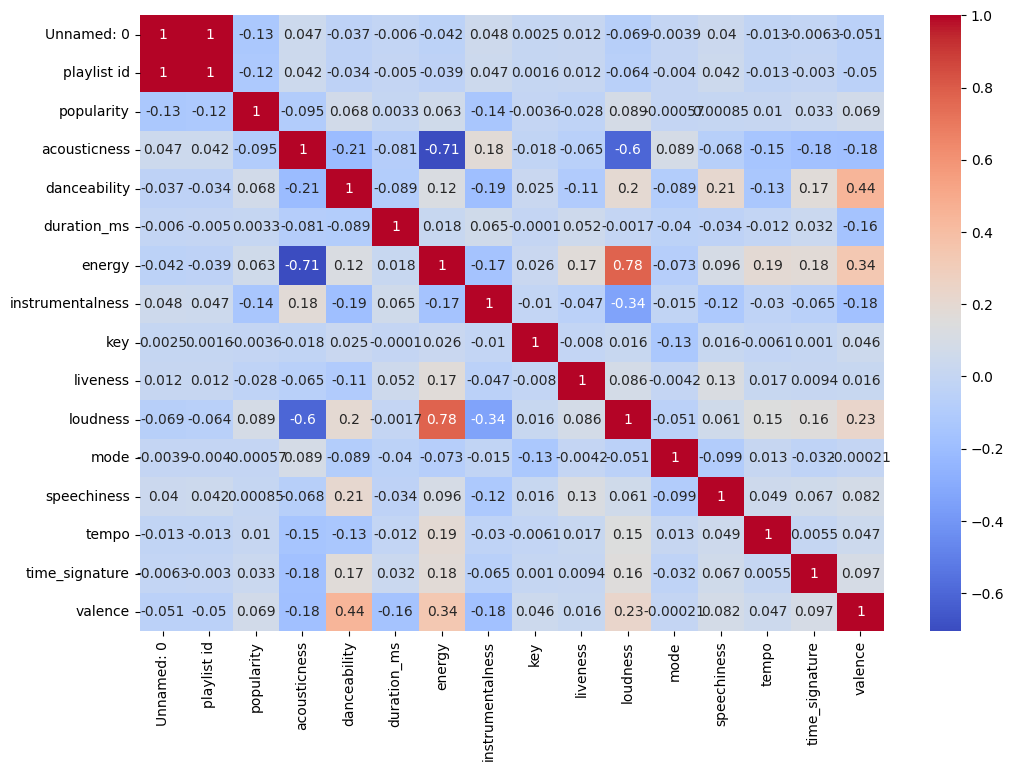

In [69]:
corr_matrix = data.corr()


plt.figure(figsize=(12, 8))

sb.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()

From the correlation matrix we can detect there are only a few features with correlation to others. Some good potential dependent features would be valence, loudness, energy, danceability, or acousticness. Below I will list the dependent variable and the set of potential predictors.

valence ~ [danceability, energy]

loudness ~ [acousticness, energy, instrumentalness]

energy ~ [acousticness, loudness]

acousticness ~ [loudness, energy]


Lets create histograms of the dependent variables to determine their distribution. Then we will create scatterplots of these relationships to ensure that there is correlation between the features.


Text(0.5, 0, 'Acousticness')

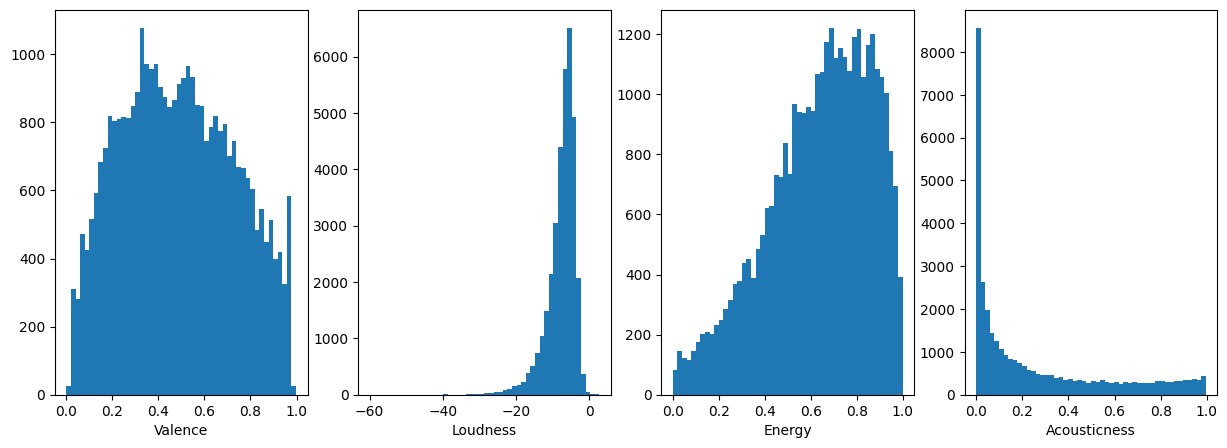

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

axes[0].hist(data['valence'], bins=50)  # Replace with your data and plotting code
axes[0].set_xlabel('Valence')

axes[1].hist(data['loudness'], bins=50)
axes[1].set_xlabel('Loudness')

axes[2].hist(data['energy'], bins=50)
axes[2].set_xlabel('Energy')

axes[3].hist(data['acousticness'], bins=50)
axes[3].set_xlabel('Acousticness')




It worries me to use acousticness and loudness as a dependent feature in a linear regression model. This is because they are either heavily right skewed (loudness) or heavily left skewed (acousticness). If I used either one I would be concerned that the variance of residuals would not be constant. This would violate the Homoscedasticity assumption of linear regression.

Text(0.5, 0, 'Energy')

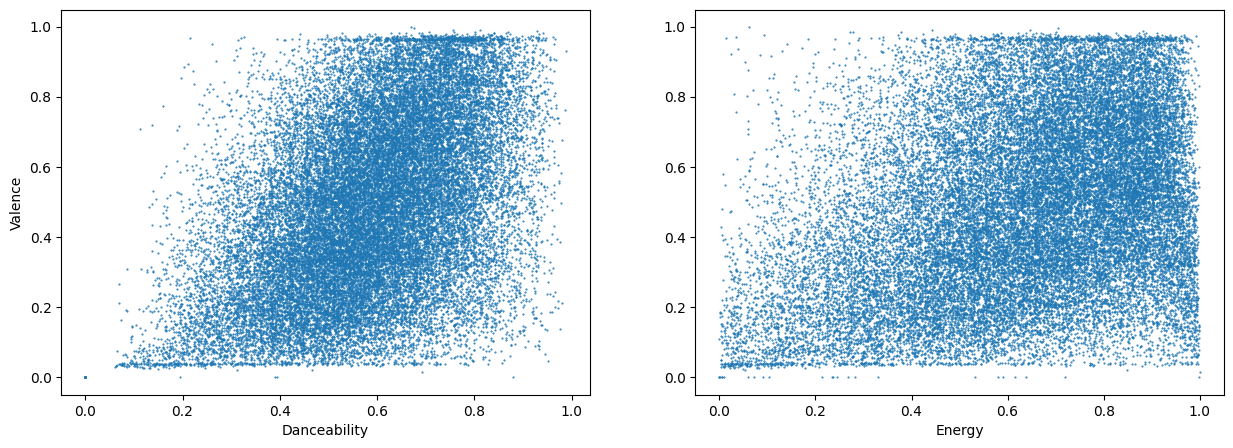

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(data['danceability'], data['valence'], 'o', markersize=.5)  # Replace with your data and plotting code
axes[0].set_xlabel('Danceability')
axes[0].set_ylabel('Valence')

axes[1].plot(data['energy'], data['valence'], 'o', markersize=.5)  # Replace with your data and plotting code
axes[1].set_xlabel('Energy')


The relationship between these features do seem to be somewhat linear as the correlation matrix suggests. I would worry about Valence ~ Energy. There does seem to be higher valence values as Energy increases, but it does not seem to be too strong.

Text(0.5, 0, 'Instrumentalness')

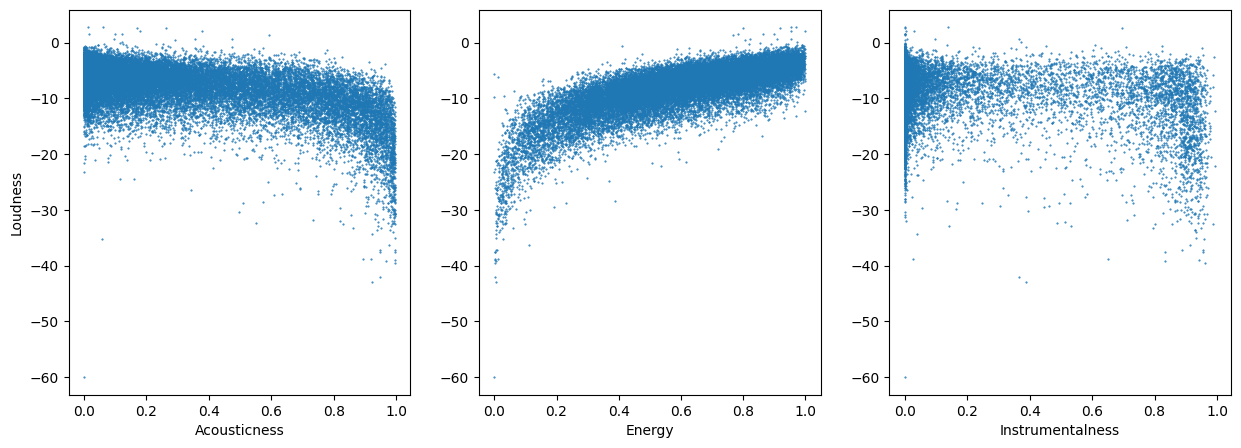

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].plot(data['acousticness'], data['loudness'], 'o', markersize=.5)  # Replace with your data and plotting code
axes[0].set_xlabel('Acousticness')
axes[0].set_ylabel('Loudness')

axes[1].plot(data['energy'], data['loudness'], 'o', markersize=.5)  # Replace with your data and plotting code
axes[1].set_xlabel('Energy')

axes[2].plot(data['instrumentalness'], data['loudness'], 'o', markersize=.5)  # Replace with your data and plotting code
axes[2].set_xlabel('Instrumentalness')


There does seem to be a negative correlation between Loudness and Acousticness and a positive correlation between Loudness and Energy. I think we can scrap the relation between Loudness and Instrumentalness as they don't seem to be correlated and the relationship is definitely not linear.

## EDA Conclusions

After interpreting this data I would surprisingly say the best feature selection would have to be Valence ~ [energy, danceability]

There are stronger correlations between loudness, energy, and acousticness. However the skewed distributions worry me as I stated before. Also all three of these features are highly correlated, this poses serious risks of multicolinearity which will impact the accuracy of the model.

When looking at Valence ~ [energy, danceability], energy and danceablity are at least moderately correlated to valence. Also energy and danceability share a .12 correlation suggesting they are not correlated. Although the correlation between Valence and Danceability is not perfect this does seem to be the best set to work with.

## Model Approach

For my model I am definately going to try to use linear regression and multi-linear regression. I will first try to predict valence by danceability alone with the linear regression model. Then I will try to predict valence by danceability and energy with the multi-linear regression model.

 If my model has poor performance I might turn this into a classification problem and determine if a song is positive or negative determined by a particular threshold in valence. I will use danceability and energy to predict this binary classification. This might improve the correation between my target and predictors and may be more accurate. I can then use a logistic regression model for this approach.

## Citation

C.W. Chen, P. Lamere, M. Schedl, and H. Zamani. Recsys Challenge 2018: Automatic Music Playlist Continuation. In Proceedings of the 12th ACM Conference on Recommender Systems (RecSys ’18), 2018.